### Ноутбук содержит реализацию следующих методов мониторинга стабильности модели:
1) Kolmogorov-Smirnov test(kstest)
2) Population Stability Index (PSI)

In [ ]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

разделим выборку по сегментам и предсатвим что каждый сегмент это одна неделя в данных,
первые 3 сегмента будем рассматривать как обучающую выборку и сравнивать распределение на первых 3х сегментах с каждым из оставшихся

In [1638]:
df = (
    pd.read_csv("../data/cs-training.csv")
    .drop(columns='Unnamed: 0')
    .rename(columns={'SeriousDlqin2yrs': 'target'})
)
df['segment2'] = np.random.choice([f'seg{i}' for i in range(15)], df.shape[0])
df.shape

(150000, 12)

In [1639]:
df.head()

,target,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,segment2
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,seg5
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,seg4
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,seg0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,seg7
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,seg8


## KS-test

In [1212]:
class KStest:
    def __init__(self):
        pass
    
    
    def get_pdf(self, values: pd.Series):
        unique_vals = list(values.unique())
        unique_vals.sort()
        n = len(values)
        pdf = []
        for val in unique_vals:
            pdf.append([val, (values == val).sum() / n])
        return pdf
    
    
    def _get_cdf(self, pdf):
        s = 0
        cdf = pdf.copy()
        for i in range(len(cdf)):
            cdf[i] = cdf[i].copy()
            s += cdf[i][1]
            cdf[i].append(s)
        return cdf
    
    
    def get_cdf(self, values: pd.Series):
        return self._get_cdf(self.get_pdf(values))
    
    
    def kstest_apply(self, sample_1, sample_2):
        sample_1_pdf = self.get_pdf(sample_1)
        sample_1_cdf = self._get_cdf(sample_1_pdf)
        
        sample_2_pdf = self.get_pdf(sample_2)
        sample_2_cdf = self._get_cdf(sample_2_pdf)

        sample_1_cdf = {val: cdf for val, _, cdf in sample_1_cdf}
        sample_2_cdf = {val: cdf for val, _, cdf in sample_2_cdf}
        unique_values = list(set(list(sample_1_cdf.keys()) + list(sample_2_cdf.keys())))
        unique_values.sort()
        
        sample_1_prev = 0
        sample_2_prev = 0
        d_val = 0
        for val in unique_values:
            if val in sample_1_cdf:
                sample_1_val = sample_1_cdf[val]
            else:
                sample_1_val = sample_1_prev
            if val in sample_2_cdf:
                sample_2_val = sample_2_cdf[val]
            else:
                sample_2_val = sample_2_prev
            d_val = max(d_val, abs(sample_1_val - sample_2_val))

            sample_1_prev = sample_1_val
            sample_2_prev = sample_2_val
        return d_val
    
    
kstest = KStest()

In [1214]:
df.nunique()

target                                       2
RevolvingUtilizationOfUnsecuredLines    125728
age                                         86
NumberOfTime30-59DaysPastDueNotWorse        16
DebtRatio                               114194
MonthlyIncome                            13594
NumberOfOpenCreditLinesAndLoans             58
NumberOfTimes90DaysLate                     19
NumberRealEstateLoansOrLines                28
NumberOfTime60-89DaysPastDueNotWorse        13
NumberOfDependents                          13
segment2                                    15
dtype: int64

In [1175]:
test_cols = list(df.columns[1:-2])

In [1177]:
max_diff = 0
p_vals = []
for column in tqdm(test_cols):
    sample1 = df.loc[df['segment2'].isin(['seg1', 'seg2', 'seg3']), column]
    sample1 = sample1.fillna(sample1.median())
    for segment in df['segment2'].unique():
        sample2 = df.loc[df['segment2'] == segment, column]
        sample2 = sample2.fillna(sample1.median())
        stat1 = stats.kstest(
            sample1,
            sample2
        ).statistic
        stat2 = kstest.kstest_apply(
            sample1,
            sample2
        )
        max_diff = max(max_diff, abs(stat1 - stat2))
        p_vals.append([
            column,
            segment,
            stats.kstest(
                sample1,
                sample2
            ).pvalue,
            max_diff
        ])

100%|██████████| 10/10 [00:52<00:00,  5.24s/it]


In [1222]:
res_df = pd.DataFrame(p_vals, columns=['columns', 'segment', 'p_val', 'max_diff'])
res_df.sort_values('p_val').head()

,columns,segment,p_val,max_diff
55,DebtRatio,seg11,0.013591,2.398082e-13
145,NumberOfDependents,seg11,0.014541,2.398082e-13
148,NumberOfDependents,seg13,0.106357,2.398082e-13
48,DebtRatio,seg10,0.115294,2.398082e-13
25,age,seg11,0.145083,1.316725e-13


видим что 2 раза уровень значимости оказался меньше 0.05, что в целом номарльно, учитывая что мы провели 150 тестов(10 фичей и 15 сегментов)

## PSI

### снова берем за эталонное распределение первые 3 сегмента и сравниваем остальные сегменты с ним

In [1544]:
psi_stats = []
for column in tqdm(test_cols):
    bins = (
        [float('-inf')] + 
        list(
            pd.qcut(
                df.loc[df['segment2'].isin(['seg1', 'seg2', 'seg3']), column], 
                q=10, 
                retbins = True,
                duplicates='drop'
            )[1][1:-1]) +
        [float('inf')]
    )
    sample_1 = df.loc[df['segment2'].isin(['seg1', 'seg2', 'seg3']), column]
    sample_1 = (pd.cut(sample_1, bins=bins).value_counts() / sample_1.shape[0]).reset_index()
    for segment in df['segment2'].unique():
        sample_2 = df.loc[df['segment2'] == segment, column]
        sample_2 = (pd.cut(sample_2, bins=bins).value_counts() / sample_2.shape[0]).reset_index()
        samples_all = sample_1.merge(sample_2, how='outer', on=column, suffixes=('_train', '_test'))
        psi = ((samples_all['count_test'] - samples_all['count_train']) * np.log(samples_all['count_test'] / samples_all['count_train'])).sum()
        psi_stats.append([column, segment, psi])

100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


In [1943]:
psi_stats_df = pd.DataFrame(psi_stats, columns=['column', 'segment', 'psi'])
psi_stats_df.sample(10)

,column,segment,psi
108,NumberRealEstateLoansOrLines,seg1,0.000051
97,NumberOfTimes90DaysLate,seg2,0.000000
45,DebtRatio,seg11,0.000578
21,age,seg0,0.002535
38,NumberOfTime30-59DaysPastDueNotWorse,seg13,0.000256
109,NumberRealEstateLoansOrLines,seg12,0.000052
10,RevolvingUtilizationOfUnsecuredLines,seg5,0.001473
47,DebtRatio,seg6,0.002583
66,MonthlyIncome,seg0,0.002153
114,NumberRealEstateLoansOrLines,seg14,0.000260


### Нарисуем для одного признака распределение в каждом сегменте и соотвествующий psi

In [1934]:
psi = []
column = 'age'
bins = (
    [float('-inf')] + 
    list(
        pd.qcut(
            df.loc[df['segment2'].isin(['seg1', 'seg2', 'seg3']), column], 
            q=10, 
            retbins = True,
            duplicates='drop'
        )[1][1:-1]) +
    [float('inf')]
)
sample_1 = df.loc[df['segment2'].isin(['seg1', 'seg2', 'seg3']), column]
sample_1 = (pd.cut(sample_1, bins=bins).value_counts() / sample_1.shape[0]).reset_index()
samples_all = sample_1.copy()
for segment in df['segment2'].unique():
    sample_2 = df.loc[df['segment2'] == segment, column]
    sample_2 = (pd.cut(sample_2, bins=bins).value_counts() / sample_2.shape[0]).reset_index()
    sample_2 = sample_2.rename(columns={'count': segment + '_distrib'})
    samples_all = samples_all.merge(sample_2, how='outer', on=column)
    psi.append([segment + '_distrib', ((samples_all[segment + '_distrib'] - samples_all['count']) * np.log(samples_all[segment + '_distrib'] / samples_all['count'])).sum()])

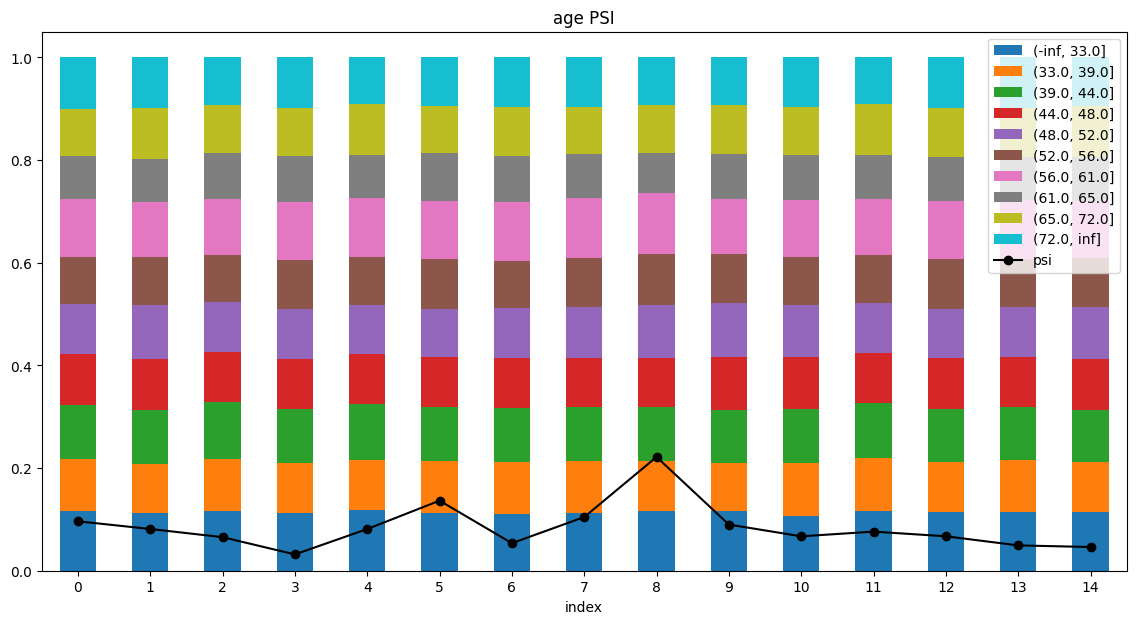

In [1964]:
backet_data = samples_all.T
backet_data.columns = backet_data.loc['age', :].values
figure, axis = plt.subplots(1, 1, figsize=(14, 7))
figure
(
    backet_data[2:]
    .reset_index()
    .assign(index=lambda x: x['index'].apply(lambda val: int(val.split('_')[0][3:])))
    .set_index('index')
    .sort_index()
).plot(    
    kind='bar', 
    stacked=True,
    ax=axis
)
(
    pd.DataFrame(psi, columns=['index', 'psi'])    
    .assign(index=lambda x: x['index'].apply(lambda val: int(val.split('_')[0][3:])))
    .set_index('index')
    .sort_index() * 100 # psi очень маленький, поэтому искусственно увеличим его, чтобы он был заметен на графике
).plot(
    kind='line',
    color='black',
    linestyle='solid',
    marker='o',
    ax=axis
)
plt.title('age PSI')
plt.show()

Если psi превышает пороговое значение(как правило - 0.1), считаем признак нестабилиьным. Имеет смысл смотреть на максимальный psi за все периоды/сегменты.